# Video Feature Extraction using OpenFace for Depression Detection

**Author:** Jonathan Chan Jia Hao  
**Affiliation:** Monash University Malaysia, School of Information Technology  
**Date:** October 2024

---

## Overview

This notebook implements **session-level video feature extraction** for multimodal depression detection using the Extended DAIC-WOZ (E-DAIC) dataset. The pipeline utilizes pre-computed OpenFace 2.1.0 features to extract interpretable facial characteristics including Action Units (AUs), head pose, and gaze direction, aggregating frame-level data into participant-level representations.

## Motivation

Depression manifests through visible behavioral markers such as reduced facial expressiveness, altered gaze patterns, and head movement dynamics. This notebook leverages clinically-validated facial features by:

- **Interpretable Features:** Extracting Action Units validated in psychology research
- **Computational Efficiency:** Using pre-computed OpenFace features instead of raw video processing
- **Statistical Aggregation:** Computing temporal statistics across interview sessions
- **Multimodal Compatibility:** Producing fixed-dimensional vectors for fusion pipelines

## Architecture Pipeline

### Video Modality (Session-Level)
1. **Input:** Pre-extracted OpenFace CSV files (one per participant)
2. **Feature Categories:**
   - **Action Units:** 17 facial muscle activation intensities
   - **Head Pose:** 6D head orientation (Tx, Ty, Tz, Rx, Ry, Rz)
   - **Gaze Direction:** Eye gaze vectors and angles
3. **Aggregation:** Statistical pooling (mean, std, min, max) across frames
4. **Output:** Fixed-dimensional feature vector `[~108 features]`

## Dataset Structure

**Input Files:**
- OpenFace: `/daic_data/{PID}_P/features/{PID}_OpenFace2.1.0_Pose_gaze_AUs.csv`
- Labels: `/Labels/detailed_lables.csv`

**Output Files:**
- `video_features_openface.npy`, `video_participant_ids.npy`, `video_feature_names.npy`
- `video_data_with_labels.pkl`

## Notebook Structure

### Part 1: Setup and Exploration (Cells 1-4)
1. **Environment Setup** (Cell 1): Import libraries
2. **Path Validation** (Cell 2): Verify directory structure
3. **Participant Discovery** (Cell 3): Enumerate available data
4. **Data Inspection** (Cell 4): Examine OpenFace file structure

### Part 2: Feature Extraction (Cells 5-8)
5. **Aggregation Function** (Cell 5): Define statistical pooling
6. **Batch Processing** (Cell 6): Extract features from all participants
7. **Array Conversion** (Cell 7): Convert to NumPy format and save
8. **Label Merging** (Cell 8): Combine features with depression labels

### Part 3: Visualization (Cells 9-10)
9. **Distribution Analysis** (Cell 9): Visualize key Action Unit histograms
10. **Dimensionality Reduction** (Cell 10): PCA visualization

## Technical Specifications

**Feature Categories:**

| Category | Features | Description |
|----------|----------|-------------|
| Action Units | 68 features | 17 AUs × 4 stats (mean, std, max, min) |
| Head Pose | 24 features | 6 dimensions × 4 stats |
| Gaze | 16 features | ~8 dimensions × 2 stats (mean, std) |
| **Total** | **~108 features** | Session-level aggregation |

**Key Action Units (Ekman FACS):**
- **AU01:** Inner brow raiser (surprise, worry)
- **AU04:** Brow lowerer (anger, concentration)
- **AU12:** Lip corner puller (smile)
- **AU15:** Lip corner depressor (sadness)

## Output Schema

```python
{
    'Participant_ID': int,
    'video_features': np.array,         # [~108]
    'Depression_label': int,            # Binary (0/1)
    'Depression_severity': str,         # Categorical
    'PHQ8_Score': float
}
```

---

**License:** MIT | **Contact:** jcha0091@student.monash.edu  
**Repository:** [GitHub](https://github.com/JonathanChan9001/Multimodal-Machine-Learning-and-Data-Analysis-Framework-for-Depression-Detection)

---

In [2]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


In [3]:
# Cell 2: Set up paths
BASE_DIR = Path("/home/jonathanchan/ml_data")
DAIC_DIR = BASE_DIR / "daic_data"
LABELS_DIR = BASE_DIR / "Labels"

# Verify directories exist
print(f"Base directory exists: {BASE_DIR.exists()}")
print(f"DAIC directory exists: {DAIC_DIR.exists()}")
print(f"Labels directory exists: {LABELS_DIR.exists()}")

Base directory exists: True
DAIC directory exists: True
Labels directory exists: True


In [4]:
# Cell 3: Get list of available participants
# Find all participant directories ending with _P
participant_dirs = [d for d in DAIC_DIR.iterdir() if d.is_dir() and d.name.endswith('_P')]
participant_ids = sorted([int(d.name.split('_')[0]) for d in participant_dirs])

print(f"Total participants found: {len(participant_ids)}")
print(f"ID range: {min(participant_ids)} to {max(participant_ids)}")
print(f"First 10 IDs: {participant_ids[:10]}")

Total participants found: 275
ID range: 300 to 718
First 10 IDs: [300, 301, 302, 303, 304, 305, 306, 307, 308, 309]


In [5]:
# Cell 4: Inspect a sample OpenFace file to understand structure
# Load one participant's OpenFace features to see what columns are available
sample_id = participant_ids[0]
sample_openface_path = DAIC_DIR / f"{sample_id}_P" / "features" / f"{sample_id}_OpenFace2.1.0_Pose_gaze_AUs.csv"

if sample_openface_path.exists():
    sample_df = pd.read_csv(sample_openface_path)
    print(f"Sample participant: {sample_id}")
    print(f"OpenFace file shape: {sample_df.shape}")
    print(f"\nFirst few columns: {sample_df.columns.tolist()[:20]}")
    print(f"\nFirst 3 rows:")
    print(sample_df.head(3))
    
    # Identify column types
    au_cols = [col for col in sample_df.columns if col.startswith('AU') and '_r' in col]  # AU intensities
    pose_cols = [col for col in sample_df.columns if 'pose' in col.lower()]  # Head pose
    gaze_cols = [col for col in sample_df.columns if 'gaze' in col.lower()]  # Gaze direction
    
    print(f"\nAction Unit columns (intensities): {len(au_cols)}")
    print(f"Sample AUs: {au_cols[:5]}")
    print(f"\nPose columns: {len(pose_cols)}")
    print(f"Sample poses: {pose_cols[:3]}")
    print(f"\nGaze columns: {len(gaze_cols)}")
    print(f"Sample gaze: {gaze_cols[:3]}")
else:
    print(f"OpenFace file not found: {sample_openface_path}")

Sample participant: 300
OpenFace file shape: (19458, 53)

First few columns: ['frame', 'timestamp', 'confidence', 'success', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'gaze_0_x', 'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z', 'gaze_angle_x', 'gaze_angle_y', 'AU01_r', 'AU02_r']

First 3 rows:
   frame  timestamp  confidence  success  pose_Tx  pose_Ty  pose_Tz  pose_Rx  \
0      1      0.000        0.98        1     69.5     37.7    576.8    0.221   
1      2      0.033        0.98        1     69.4     37.4    577.5    0.219   
2      3      0.067        0.98        1     69.4     37.3    576.7    0.223   

   pose_Ry  pose_Rz  ...  AU12_c  AU14_c  AU15_c  AU17_c  AU20_c  AU23_c  \
0    0.036   -0.068  ...     0.0     1.0     0.0     0.0     0.0     1.0   
1    0.037   -0.067  ...     0.0     1.0     1.0     1.0     0.0     1.0   
2    0.039   -0.069  ...     0.0     1.0     1.0     1.0     0.0     1.0   

   AU25_c  AU26_c  AU28_c  AU45_c  
0     0.

In [6]:
# Cell 5: Define feature extraction function
def extract_openface_features(openface_df):
    """
    Extract aggregated features from frame-level OpenFace data
    
    Args:
        openface_df: DataFrame with OpenFace features (one row per frame)
    
    Returns:
        Dictionary of aggregated features
    """
    features = {}
    
    # Identify feature columns
    # AU intensity columns end with '_r' (e.g., AU01_r, AU02_r, etc.)
    au_cols = [col for col in openface_df.columns if col.startswith('AU') and '_r' in col]
    
    # Pose columns (head orientation: pitch, yaw, roll)
    pose_cols = ['pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz']
    pose_cols = [col for col in pose_cols if col in openface_df.columns]
    
    # Gaze direction columns
    gaze_cols = [col for col in openface_df.columns if 'gaze' in col.lower() and 'angle' not in col.lower()]
    
    # Aggregate Action Units: mean, std, max, min
    for au in au_cols:
        au_name = au.replace('_r', '')  # Remove '_r' suffix for cleaner names
        features[f'{au_name}_mean'] = openface_df[au].mean()
        features[f'{au_name}_std'] = openface_df[au].std()
        features[f'{au_name}_max'] = openface_df[au].max()
        features[f'{au_name}_min'] = openface_df[au].min()
    
    # Aggregate Head Pose: mean, std, max, min
    for pose in pose_cols:
        features[f'{pose}_mean'] = openface_df[pose].mean()
        features[f'{pose}_std'] = openface_df[pose].std()
        features[f'{pose}_max'] = openface_df[pose].max()
        features[f'{pose}_min'] = openface_df[pose].min()
    
    # Aggregate Gaze: mean, std
    for gaze in gaze_cols:
        features[f'{gaze}_mean'] = openface_df[gaze].mean()
        features[f'{gaze}_std'] = openface_df[gaze].std()
    
    return features

# Test on sample participant
if sample_openface_path.exists():
    sample_features = extract_openface_features(sample_df)
    print(f"Extracted {len(sample_features)} features")
    print(f"\nFirst 10 features:")
    for i, (key, value) in enumerate(list(sample_features.items())[:10]):
        print(f"  {key}: {value:.4f}")

Extracted 104 features

First 10 features:
  AU01_mean: 0.2974
  AU01_std: 0.5833
  AU01_max: 4.0500
  AU01_min: 0.0000
  AU02_mean: 0.1315
  AU02_std: 0.3371
  AU02_max: 2.8800
  AU02_min: 0.0000
  AU04_mean: 0.1226
  AU04_std: 0.2634


In [7]:
# Cell 6: Process all participants
def process_all_video(participant_ids, daic_dir):
    """
    Process OpenFace features for all participants
    
    Returns:
        features_dict: dict mapping participant_id -> feature dictionary
        failed: list of participant IDs that failed
    """
    features_dict = {}
    failed = []
    
    total = len(participant_ids)
    
    for i, pid in enumerate(participant_ids):
        try:
            # Construct OpenFace file path
            openface_path = daic_dir / f"{pid}_P" / "features" / f"{pid}_OpenFace2.1.0_Pose_gaze_AUs.csv"
            
            # Check if file exists
            if not openface_path.exists():
                print(f"OpenFace file not found for participant {pid}")
                failed.append(pid)
                continue
            
            # Load OpenFace data
            openface_df = pd.read_csv(openface_path)
            
            # Extract aggregated features
            features = extract_openface_features(openface_df)
            
            # Store features
            features_dict[pid] = features
            
            # Progress update every 25 participants
            if (i + 1) % 25 == 0:
                print(f"Processed {i + 1}/{total} participants")
                
        except Exception as e:
            print(f"Failed participant {pid}: {e}")
            failed.append(pid)
    
    return features_dict, failed

# Process all participants
print(f"Starting video feature extraction for {len(participant_ids)} participants...")
print("This should take about 5-10 minutes...\n")

features_dict, failed_ids = process_all_video(participant_ids, DAIC_DIR)

print(f"\n{'='*50}")
print(f"Processing complete!")
print(f"Successfully processed: {len(features_dict)}")
print(f"Failed: {len(failed_ids)}")
if failed_ids:
    print(f"Failed IDs: {failed_ids[:10]}{'...' if len(failed_ids) > 10 else ''}")

Starting video feature extraction for 275 participants...
This should take about 5-10 minutes...

Processed 25/275 participants
Processed 50/275 participants
Processed 75/275 participants
Processed 100/275 participants
Processed 125/275 participants
Processed 150/275 participants
Processed 175/275 participants
Processed 200/275 participants
Processed 225/275 participants
Processed 250/275 participants
Processed 275/275 participants

Processing complete!
Successfully processed: 275
Failed: 0


In [8]:
# Cell 7: Convert features to arrays and save
# Convert dictionary of dictionaries to structured format
# Each participant has a dict of features -> convert to fixed-order array

# Get feature names from first participant (they should all have same features)
first_pid = list(features_dict.keys())[0]
feature_names = list(features_dict[first_pid].keys())

print(f"Total features per participant: {len(feature_names)}")
print(f"Feature names sample: {feature_names[:5]}")

# Convert to array format
sorted_ids = sorted(features_dict.keys())
features_array = []

for pid in sorted_ids:
    # Extract feature values in consistent order
    feature_vector = [features_dict[pid][fname] for fname in feature_names]
    features_array.append(feature_vector)

features_array = np.array(features_array)
participant_ids_array = np.array(sorted_ids)

# Save as numpy arrays
np.save(BASE_DIR / 'video_features_openface.npy', features_array)
np.save(BASE_DIR / 'video_participant_ids.npy', participant_ids_array)
np.save(BASE_DIR / 'video_feature_names.npy', np.array(feature_names))  # Save feature names for reference

print(f"\nSaved video features:")
print(f"  Features shape: {features_array.shape}")
print(f"  Participant IDs shape: {participant_ids_array.shape}")
print(f"  Location: {BASE_DIR}")
print(f"\nFeature statistics:")
print(f"  Mean: {features_array.mean():.4f}")
print(f"  Std: {features_array.std():.4f}")
print(f"  Min: {features_array.min():.4f}")
print(f"  Max: {features_array.max():.4f}")

Total features per participant: 104
Feature names sample: ['AU01_mean', 'AU01_std', 'AU01_max', 'AU01_min', 'AU02_mean']

Saved video features:
  Features shape: (275, 104)
  Participant IDs shape: (275,)
  Location: /home/jonathanchan/ml_data

Feature statistics:
  Mean: 13306.3839
  Std: 1810477.2883
  Min: -16093360.0000
  Max: 239962352.0000


In [9]:
# Cell 8: Merge with labels
# Create dataframe with features
video_df = pd.DataFrame({
    'Participant_ID': participant_ids_array,
})

# Add features as a list (similar to text/audio embeddings)
video_df['video_features'] = list(features_array)

# Load labels
detailed_labels = pd.read_csv(LABELS_DIR / "detailed_lables.csv")

# Merge with labels
merged_data = video_df.merge(
    detailed_labels,
    left_on='Participant_ID',
    right_on='Participant',
    how='inner'
)

print(f"Merged dataset:")
print(f"  Total rows: {len(merged_data)}")
print(f"  Columns: {merged_data.columns.tolist()}")
print(f"\nDepression label distribution:")
print(merged_data['Depression_label'].value_counts())
print(f"\nDepression severity distribution:")
print(merged_data['Depression_severity'].value_counts().sort_index())

# Save merged dataset
merged_data.to_pickle(BASE_DIR / 'video_data_with_labels.pkl')
print(f"\nSaved merged dataset to: {BASE_DIR / 'video_data_with_labels.pkl'}")

Merged dataset:
  Total rows: 275
  Columns: ['Participant_ID', 'video_features', 'Participant', 'PHQ8_1_NoInterest', 'PHQ8_2_Depressed', 'PHQ8_3_Sleep', 'PHQ8_4_Tired', 'PHQ8_5_Appetite', 'PHQ8_6_Failure', 'PHQ8_7_Concentration', 'PHQ8_8_Psychomotor', 'Depression_severity', 'PCL-C_1_Memories', 'PCL-C_2_Dreams', 'PCL-C_3_Reliving', 'PCL-C_4_Upset', 'PCL-C_5_Physical', 'PCL-C_6_ThoughtAvoidance', 'PCL-C_7_ActivityAvoidance', 'PCL-C_8_TroubleRemembering', 'PCL-C_9_NoInterest', 'PCL-C_10_FeelDistant', 'PCL-C_11_FeelNumb', 'PCL-C_12_Future_Cut_Short', 'PCL-C_13_Sleep', 'PCL-C_14_Irritability', 'PCL-C_15_Concentration', 'PCL-C_16_HyperAlert', 'PCL-C_17_Jumpy', 'PTSD_severity', 'gender', 'age', 'Depression_label', 'PTSD_label', 'split']

Depression label distribution:
Depression_label
0    209
1     66
Name: count, dtype: int64

Depression severity distribution:
Depression_severity
0     42
1     22
2     24
3     21
4     13
5     15
6      9
7     22
8      8
9     13
10    13
11     9
12 

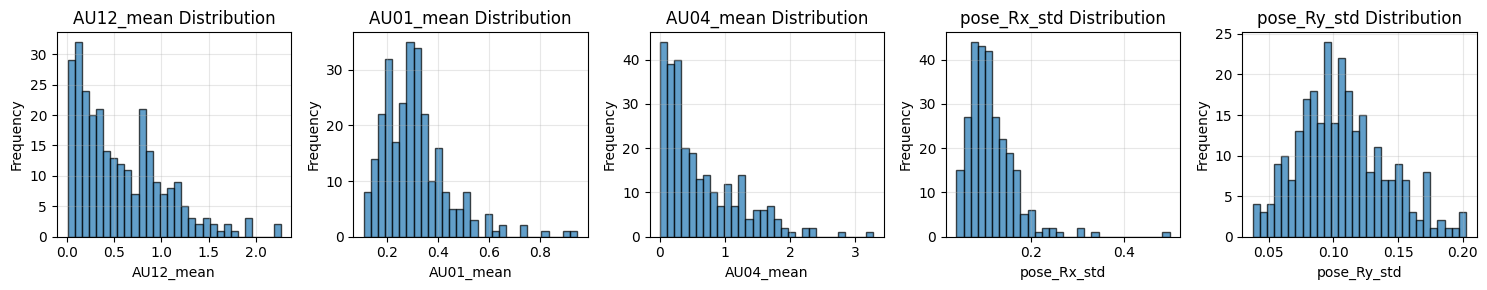

Feature distributions plotted
AU12 = Lip corner puller (smiling)
AU01 = Inner brow raiser
AU04 = Brow lowerer
pose_Rx/Ry = Head rotation (pitch/yaw)


In [10]:
# Cell 9: Visualize feature distributions
import matplotlib.pyplot as plt

# Select a few key features to visualize
key_features = ['AU12_mean', 'AU01_mean', 'AU04_mean', 'pose_Rx_std', 'pose_Ry_std']
key_indices = [feature_names.index(f) for f in key_features if f in feature_names]

if key_indices:
    fig, axes = plt.subplots(1, len(key_indices), figsize=(15, 3))
    
    for idx, feat_idx in enumerate(key_indices):
        ax = axes[idx] if len(key_indices) > 1 else axes
        ax.hist(features_array[:, feat_idx], bins=30, alpha=0.7, edgecolor='black')
        ax.set_xlabel(feature_names[feat_idx])
        ax.set_ylabel('Frequency')
        ax.set_title(f'{feature_names[feat_idx]} Distribution')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Feature distributions plotted")
    print("AU12 = Lip corner puller (smiling)")
    print("AU01 = Inner brow raiser")
    print("AU04 = Brow lowerer")
    print("pose_Rx/Ry = Head rotation (pitch/yaw)")
else:
    print("Key features not found for visualization")

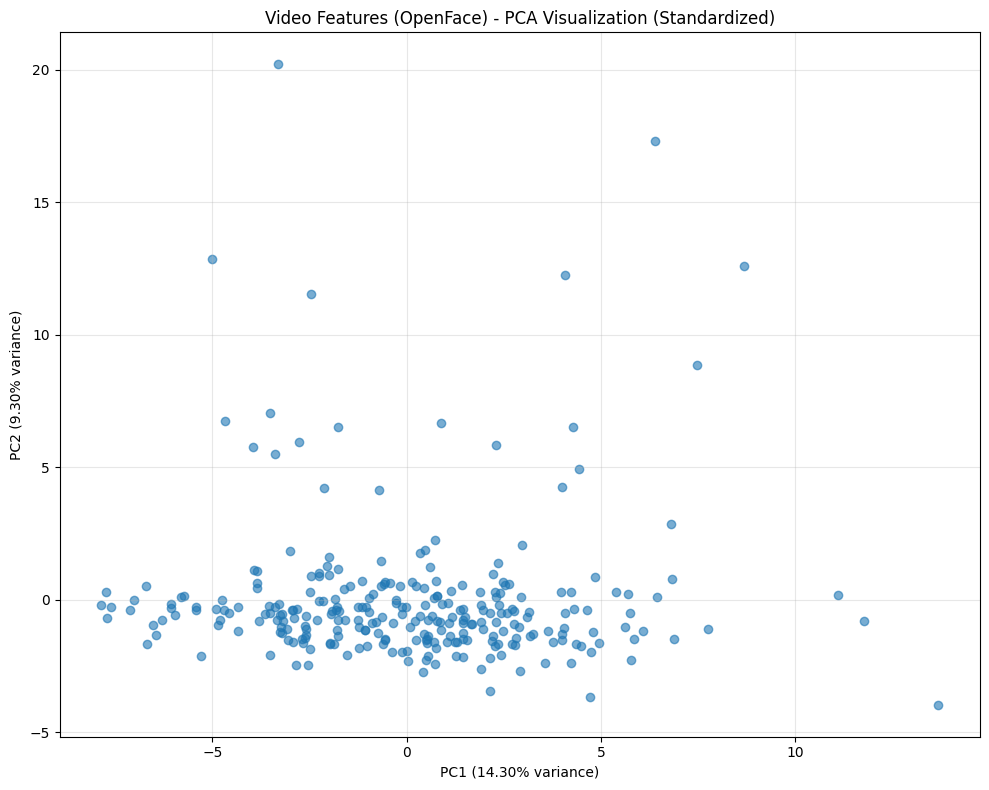

In [11]:
# Cell 10: PCA with standardization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features first to handle different scales
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# Apply PCA to scaled features
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.6)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Video Features (OpenFace) - PCA Visualization (Standardized)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()